In [46]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)


# Lectura de bases de datos

In [48]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.add_year_month_day(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")

In [49]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.add_year_month_day(df_procedimientos, "fecha_realizacion")
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

fecha_minimo_procedimientos = min(df_procedimientos.fecha_realizacion)
fecha_maximo_procedimientos = max(df_procedimientos.fecha_realizacion)

## Analisis de cantidad de consultas y procedimientos

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-02 00:00:00 y  2022-08-31 00:00:00


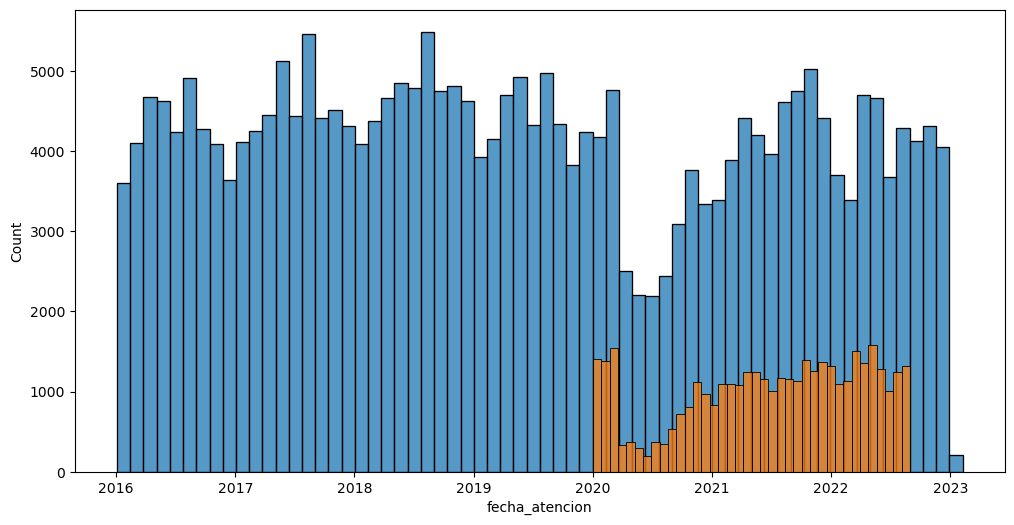

In [50]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
print(
    f"El rango de fechas de procedimientos es entre {fecha_minimo_procedimientos} y "
    f" {fecha_maximo_procedimientos}"
)

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()

- Por lo tanto, ambas bases deben estar con el mismo rango temporal. Se procedera a filtrar
la base de diagnosticos

In [51]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_minimo_procedimientos) & (
    df_diagnosticos["fecha_atencion"] <= fecha_maximo_procedimientos
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39484 procedimientos


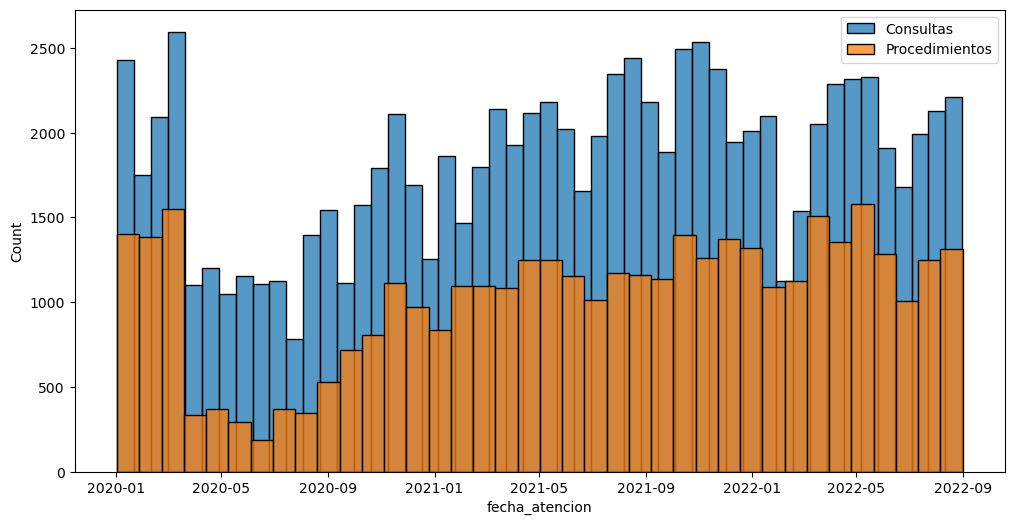

In [52]:
print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()

- Luego, se eliminaran todos los registros que carezcan de una fecha de consulta o procedimientos

In [53]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39472 procedimientos


- Por lo tanto, la base de consultas carecia de fechas de atencion faltantes. Sin embargo, la
base de procedimientos presentaba 33 fechas faltantes.

# Analisis a lo largo del tiempo

En este analisis se quieren obtener los siguientes insights:

- Frecuencia de diagnosticos por anio
- Rango etario por anio
- Sexo por anio

Ademas, se quieren obtener las siguientes variables para los pacientes

- Prevision
- Servicio de Salud
- Comuna

Para esto, se utilizara la base de datos estadisticos y se uniran en base al id del paciente

In [97]:
datos_pacientes = (
    df_procedimientos.value_counts(
        ["id_paciente", "comuna_residencia", "prevision", "servicio_salud"]
    )
    .reset_index()
    .drop(columns=0)
)

In [98]:
df_diagnosticos_datos_paciente = pd.merge(
    df_diagnosticos, datos_pacientes, how="left", on="id_paciente"
)

In [99]:
desglose_sociodemografico = ["ano"]

variables_a_analizar = ["codigo_diagnostico", "sexo", "rango_etario_primera_consulta",
                        "comuna_residencia", "prevision", "servicio_salud"]


In [100]:
resultados_sociodemo = build_features.obtener_dfs_para_desglose_sociodemografico(
    df_diagnosticos_datos_paciente,
    desglose_sociodemografico,
    variables_a_analizar,
    "codigo_diagnostico",
)

In [56]:
with pd.ExcelWriter("../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx") as file:
    for nombre_hoja, df_a_guardar in resultados_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

# Analisis de procedimientos y diagnosticos

- En este apartado se quiere realizar un analisis de cuales procedimientos se le realizan a cada
diagnostico en ambulatorios. La primera forma de resolverlo es de la siguiente forma:

## 1. Union de procedimientos que se hayan realizado dentro de la misma consulta

- Se enlaza por el ID del paciente y la fecha de realizacion de la consulta/procedimiento. Esto
asume que dentro de la consulta se realizo un procedimiento. Por ejemplo: Paciente X con fecha 
de consulta el 21-07-2022 y fecha de procedimiento el 21-07-2022. En lo anterior se enlaza y 
se obtiene la dulpa diagnostico/procedimiento.

In [57]:
diags_con_indice = df_diagnosticos_acotado.set_index(["id_paciente", "year", "month", "day"])
proced_con_indice = df_procedimientos.set_index(["id_paciente", "year", "month", "day"])

In [58]:
union = pd.merge(
    diags_con_indice, proced_con_indice, left_index=True, right_index=True, how="inner"
).reset_index()

In [59]:
cantidad_consultas_unicas = union.value_counts(["id_paciente", "fecha_atencion"]).shape[0]
consultas_sin_unir = df_diagnosticos_acotado.shape[0] - cantidad_consultas_unicas

procedimientos_sin_unir = df_procedimientos.shape[0] - union.shape[0]

print(f"> La union de ambas bases de datos genero {union.shape[0]} filas. " 
      f"Por lo tanto, se unieron la misma cantidad de procedimientos")
print(f"> Se unieron {cantidad_consultas_unicas} consultas, y {consultas_sin_unir} consultas "
      f"quedaron sin procedimientos")
print(f"> {procedimientos_sin_unir} procedimientos quedaron sin unir")

> La union de ambas bases de datos genero 10804 filas. Por lo tanto, se unieron la misma cantidad de procedimientos
> Se unieron 6674 consultas, y 85242 consultas quedaron sin procedimientos
> 28668 procedimientos quedaron sin unir


- Lo anterior da cuenta de que existe una parte importante de procedimientos/consultas que
quedan sin enlazar

In [60]:
cantidad_diagnosticos = union.groupby(["year"])[
    ["codigo_diagnostico", "nombre_diagnostico"]
].value_counts().reset_index(name="conteo")

cantidad_procedimientos = union.groupby(["year", "codigo_diagnostico", "nombre_diagnostico"])[
    ["cod", "glosa"]
].value_counts().reset_index(name="conteo")

resultados_procedimientos = {"diags": cantidad_diagnosticos,
                             "proced": cantidad_procedimientos}

In [61]:
with pd.ExcelWriter("../data/processed/tableros_powerbi/procedimientos.xlsx") as file:
    for nombre_hoja, df_a_guardar in resultados_procedimientos.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)


## 2. Obtener el diagnostico del paciente y llevarlo a los procedimientos

- La idea es enlazar solamente por ID_paciente el procedimiento/diagnostico. Sin embargo, un mismo
paciente puede tener diversos diagnosticos a lo largo del tiempo. Debido a lo anterior, es que se
necesita identificar el diagnostico que este mas cerca de la fecha del procedimiento

- Primero se debe saber si es que todos los pacientes de procedimientos estan en diagnosticos:

In [62]:
pacientes_consultas = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_procedimientos = set(df_procedimientos.id_paciente.unique())
diferencia_pacientes_consultas = pacientes_consultas - pacientes_procedimientos
diferencia_pacientes_procedimientos = pacientes_procedimientos - pacientes_consultas
pacientes_en_ambas = pacientes_consultas & pacientes_procedimientos

print(f"> La base de consultas tiene {len(pacientes_consultas)} pacientes distintos")
print(f"> La base de procedimientos tiene {len(pacientes_procedimientos)} pacientes distintos\n")
print(f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
      f"en las consultas")
print(f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
      f" en procedimientos\n")
print(f"> Hay {len(pacientes_en_ambas)} pacientes que estan en ambas bases de datos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 14737 pacientes distintos

> Hay una diferencia de 11020 pacientes que solo estan en las consultas
> Hay una diferencia de 2544 pacientes que solo estan en procedimientos

> Hay 12193 pacientes que estan en ambas bases de datos


- La diferencia entre pacientes puede ocurrir debido a que ninguno de estos se ha hecho algun
procedimiento durante su consulta.

- Para reducir el costo computacional, se dejaran solamente los pacientes que esten en ambas bases
de datos

In [63]:
diags_pacientes_comunes = df_diagnosticos_acotado[
    df_diagnosticos_acotado.id_paciente.isin(pacientes_en_ambas)
]
proced_pacientes_comunes = df_procedimientos[df_procedimientos.id_paciente.isin(pacientes_en_ambas)]

- Ahora, en la base de procedimientos se deben obtener las duplas unicas entre id_paciente y
fecha_realizacion para reducir el costo computacional en la busqueda.

In [64]:
dupla_pacientes = proced_pacientes_comunes[["id_paciente", "fecha_realizacion"]].value_counts().index


In [65]:
resultados_pacientes = []
for id_paciente, fecha_procedimiento in dupla_pacientes:
    df_paciente = diags_pacientes_comunes.query("id_paciente == @id_paciente")
    diag_mas_cercano = build_features.obtener_diag_mas_cercano(df_paciente, fecha_procedimiento)
    resultados_pacientes.append(diag_mas_cercano)

In [66]:
pacientes_y_diags = pd.DataFrame(resultados_pacientes, index=dupla_pacientes)
pacientes_y_diags.columns = ["codigo_diagnostico"]
proced_comunes_indice = proced_pacientes_comunes.set_index(["id_paciente", "fecha_realizacion"])
union_procedimientos_2 = pd.merge(
    proced_comunes_indice, pacientes_y_diags, how="inner", left_index=True, right_index=True
).reset_index()

In [67]:
union_procedimientos_2

,id_paciente,fecha_realizacion,sexo,edad,prevision,servicio_salud,comuna_residencia,unidad_que_la_realiza,subtipo,cod,glosa,cerrado/abierto,mes,ano,year,month,day,codigo_diagnostico
0,00022378f6235c5aa96a8c5ef7c0009ddf55e5e381d8d0...,2022-01-13,Femenino,75,Beneficiario B,Metropolitano Oriente (SSMO),La Florida,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 013,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,ABIERTA,01.ENERO,2022.0,2022.0,1.0,13.0,J67
1,00051e9fd6d17e273f5e41c4a9e7283ec4a0bde61ecfbc...,2020-01-13,Masculino,65,Beneficiario D,Metropolitano Oriente (SSMO),Las Condes,IMAGENOLOGÍA,SIMPLE,04 01 070,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,ABIERTA,01.ENERO,2020.0,2020.0,1.0,13.0,J4484
2,00051e9fd6d17e273f5e41c4a9e7283ec4a0bde61ecfbc...,2022-01-12,Masculino,67,Beneficiario D,Metropolitano Oriente (SSMO),Las Condes,IMAGENOLOGÍA,SIMPLE,04 01 070,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,ABIERTA,01.ENERO,2022.0,2022.0,1.0,12.0,J4484
3,00056e0f1ae5c12f7799b64d27ff963656acfcb0896d92...,2021-05-11,Masculino,75,Beneficiario B,Metropolitano Oriente (SSMO),Peñalolen,HEMODINAMÍA,",",17 01 019,CINECORONARIOGRAFIA DERECHA Y/O IZQUIERDA (INC...,ABIERTA,05.MAYO,2021.0,2021.0,5.0,11.0,R060
4,0010a2bec0d086bc746de6fa3de5bc2062111548a7a828...,2022-02-17,Masculino,82,Beneficiario D,Aconcagua,Los Andes,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 013,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,ABIERTA,02.FEBRERO,2022.0,2022.0,2.0,17.0,J849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34923,fffa43f2948cd8087a379fd9cfe75435a6fc83209cf013...,2022-08-04,Femenino,79,Beneficiario D,Metropolitano Oriente (SSMO),Ñuñoa,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 103,TOMOGRAFIA COMPUTARIZADA ANGIO DE ABDOMEN,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,4.0,I069
34924,fffa43f2948cd8087a379fd9cfe75435a6fc83209cf013...,2022-08-04,Femenino,79,Beneficiario D,Metropolitano Oriente (SSMO),Ñuñoa,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 105,TOMOGRAFIA COMPUTARIZADA ANGIO DE PELVIS,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,4.0,I069
34925,fffa43f2948cd8087a379fd9cfe75435a6fc83209cf013...,2022-08-04,Femenino,79,Beneficiario D,Metropolitano Oriente (SSMO),Ñuñoa,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 102,TOMOGRAFIA COMPUTARIZADA ANGIO DE TORAX,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,4.0,I069
34926,fffa43f2948cd8087a379fd9cfe75435a6fc83209cf013...,2022-08-04,Femenino,79,Beneficiario D,Metropolitano Oriente (SSMO),Ñuñoa,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 106,TOMOGRAFIA COMPUTARIZADA DE ANGIO CARDIACO. MI...,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,4.0,I069
